<a href="https://colab.research.google.com/github/ishika-mittal/Stock-Prices-Analytics-Dashboard/blob/main/SPAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SECTION 1: CLOSING PRICE PREDICTION BASED ON NEURAL NETWORKS**

Hey! In this section, I will be reading the data for all the tinkering we will be doing ahead and also implement the LSTM Network on it for closing price prediction.


The Plan of Action is:
*   Data Fetching through yfinance
*   Data Preparation
*   Building the LSTM Network
*   Implementing it on our data

## **Part 1: Data Collection**

In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Installing yfinance library for fetching historical stock data
!pip install yfinance
import yfinance as yf

In [ ]:
#Function to get the stock data
def stock_data(stock, start_date, end_date):

    tickerSymbol = stock

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

    return tickerDf

In [ ]:
#Fetching data

df = stock_data("ITC.BO", "2011-06-08", "2021-06-08")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-06-08,101.296763,102.791816,101.244306,102.136093,570295,0.0,0.0
2011-06-09,102.188547,102.686898,101.375440,102.267227,429328,0.0,0.0
2011-06-10,101.420746,102.267240,100.785872,101.394287,687543,1.1,0.0
2011-06-13,101.314928,101.711729,100.653608,100.971039,669849,0.0,0.0
2011-06-14,101.050409,102.796310,101.050409,102.505325,513403,0.0,0.0


## **Part 2: Exploratory Data Analysis**

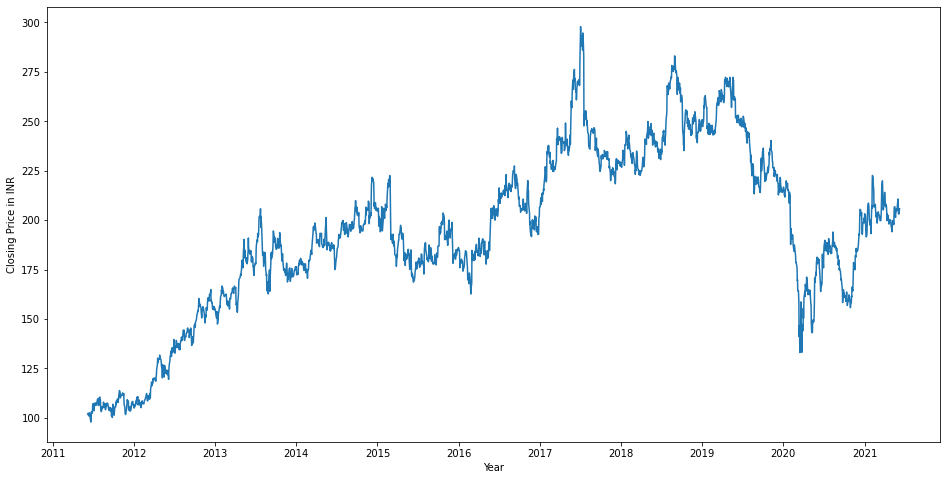

In [ ]:
#plotting fetched data
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.plot(df['Close'], label='Close Price history')

In [ ]:
#Checking the data types
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [ ]:
#Checking for data consistency, missing values, measures of central tendency, dispersion
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2459.000000,2459.000000,2459.000000,2459.000000,2.459000e+03,2459.000000,2459.000000
mean,194.164962,196.018209,191.801647,193.811047,8.897098e+05,0.019479,0.000610
std,42.643026,42.862788,42.253953,42.430514,9.861227e+05,0.329482,0.030249
min,97.876044,98.828344,96.447576,97.902496,0.000000e+00,0.000000,0.000000
25%,173.095039,174.531831,170.534772,172.617638,3.931850e+05,0.000000,0.000000
50%,193.823091,195.793749,191.170334,193.276474,5.872400e+05,0.000000,0.000000
75%,226.322617,228.240783,224.172425,225.665733,1.022740e+06,0.000000,0.000000
max,300.448458,307.366833,296.140787,297.881256,1.312159e+07,10.150000,1.500000


## **Part 3: Data Preprocessing**

In [ ]:
#Resetting index to make date a column
df.reset_index(level="Date", inplace=True)

In [ ]:
#Dropping columns which are not required
df.drop(columns = ['Dividends', 'Stock Splits'], inplace=True)

In [ ]:
#Creating a dataset with only Closing Price column and Date as index

data = df.sort_index(ascending=True,axis=0)
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df1["Date"][i]=data['Date'][i]
    df1["Close"][i]=data["Close"][i]

df1.index=df1.Date
df1.drop("Date",axis=1,inplace=True)
df1.head()

,Close
Date,
2011-06-08,102.136
2011-06-09,102.267
2011-06-10,101.394
2011-06-13,100.971
2011-06-14,102.505


In [ ]:
#Splitting data into train and test, using manual spliting as time series data is ordered
data = df1.values
train = data[0:1750,:]
test = data[1750:,:]

print(train.shape)
print(test.shape)

(1750, 1)
(709, 1)


In [ ]:
#LSTM is very sensitive to variance and scale of data, hence normalizing it in the range of 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [ ]:
#Preparing train data

x_train,y_train=[],[]

#Setting up a time window, the model will be using past window (in this case 60 days) of data to predict the next closing price
window = 60

for i in range(window,len(train)):
    x_train.append(scaled_data[i-window:i,0])
    y_train.append(scaled_data[i,0])

#Converting dataframe to numpy array input  
x_train,y_train = np.array(x_train),np.array(y_train)
# reshaping input to be [samples, time steps, features] which is required for LSTM
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Preparing test data
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
for i in range(window,inputs.shape[0]):
    x_test.append(inputs[i-window:i,0])

#Converting dataframe to numpy array input
x_test = np.array(x_test)
#Reshaping input to be [samples, time steps, features] which is required for LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Checking the input data
print(x_train[0][0])
print(y_train[0])

[0.02117023]
0.04695898948008387


## **Part 4: Building the Model**

In [ ]:
#importing libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
#Creating the LSTM Network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model
model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=2)

27/27 - 5s - loss: 0.0313


In [ ]:
#Prediction
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

##Transformback to original form
closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

In [ ]:
#Performance Metric on Test Data
import math
from sklearn.metrics import mean_squared_error

mse = math.sqrt(mean_squared_error(test,closing_price))
mse

12.654447519413388

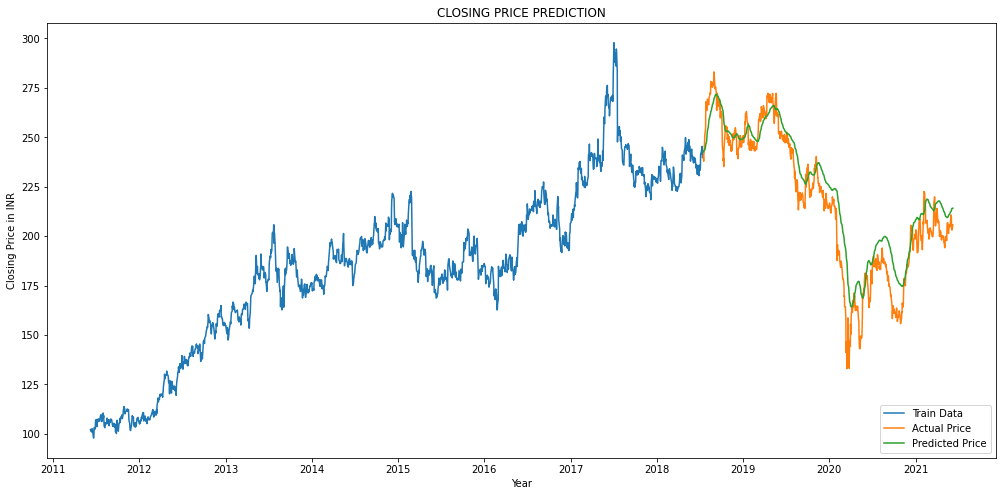

In [ ]:
#Plotting the predictions
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.title("CLOSING PRICE PREDICTION")

#Let's go
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc ="lower right")
plt.show()

# **SECTION 2: TECHNICAL INDICATORS**

In this section, I will be implementing the most prominent Techincal Indicators used in Stock Market Techincal Analyis. As we go, I have attempted to breakdown the financial understanding of each indicator too along with supporting resources.

...

List of Technical Indicators covered:

*   Simple Moving Average (SMA)
*   Exponential Moving Average (EMA)
*   Relative Strength Index (RSI)
*   Stochastic Oscillator
*   Bollinger Bands
*   Moving average convergence divergence (MACD)
*   Money Flow Index (MFI)


In [ ]:
#Ftching a 1Y dataset for better representation

df = stock_data("ITC.BO", "2020-06-08", "2021-06-08")
df.reset_index(level="Date", inplace=True)
df.drop(columns = ['Dividends', 'Stock Splits'], inplace=True)

print(df.shape)
df.head()

(250, 6)


,Date,Open,High,Low,Close,Volume
0,2020-06-08,182.945035,184.074883,178.199672,178.742004,744734
1,2020-06-09,179.826649,186.289389,178.696801,179.510300,1341970
2,2020-06-10,180.052627,183.668142,179.284339,180.097824,1024793
3,2020-06-11,180.775730,181.905578,174.990912,175.894791,855456
4,2020-06-12,171.375387,176.482296,169.974373,175.352448,980250


In [ ]:
#Creating a dataset with only Closing Price column and Date as index

data = df.sort_index(ascending=True,axis=0)
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df1["Date"][i]=data['Date'][i]
    df1["Close"][i]=data["Close"][i]

df1.index=df1.Date
df1.drop("Date",axis=1,inplace=True)
print(df1.shape)
df1.head()

(250, 1)


,Close
Date,
2020-06-08,178.742
2020-06-09,179.51
2020-06-10,180.098
2020-06-11,175.895
2020-06-12,175.352


### **I1: Simple Moving Average (SMA)**

1. There simple objective to smoothen the fluctuation by determining an avergae price within the given time period.

2. They help analyse and predict the trend of the stock. A rising SMA-> uptrend, while a declining SMA-> downtrend.

3. You can also plot SMAs with two different time periods to identify crossover. An upward momentum is confirmed with a bullish crossover, which occurs when a short-term moving average crosses above a longer-term moving average. Conversely, downward momentum is confirmed with a bearish crossover, which occurs when a short-term moving average crosses below a longer-term moving average.

4. There is no fixed time period for calculating SMA. Shorter moving averages are typically used for short-term trading, while longer-term moving averages are more suited for long-term investors.

Detailed Explanation - https://www.investopedia.com/terms/m/movingaverage.asp

In [ ]:
#Defining the function

def MA(data, window_size):

  data1 = data
  data1 = pd.Series(data1["Close"])

  #Calculating Moving average for a given time period
  moving_avg = data1.rolling(window = window_size).mean()
  #Parsing the results as a new column in the existing data frame
  data["Moving_Avg"] = moving_avg

  return data

In [ ]:
#Implementing the function
MA(df1,30)

#Note: First window_size values under Moving_avg as empty as they are used in inital calculation
df1.iloc[20:30,:]

,Close,Moving_Avg
Date,,
2020-07-06,189.843,NaN
2020-07-07,184.663,NaN
2020-07-08,186.516,NaN
2020-07-09,185.756,NaN
2020-07-10,184.663,NaN
2020-07-13,187.657,NaN
2020-07-14,186.279,NaN
2020-07-15,188.655,NaN
2020-07-16,184.235,NaN


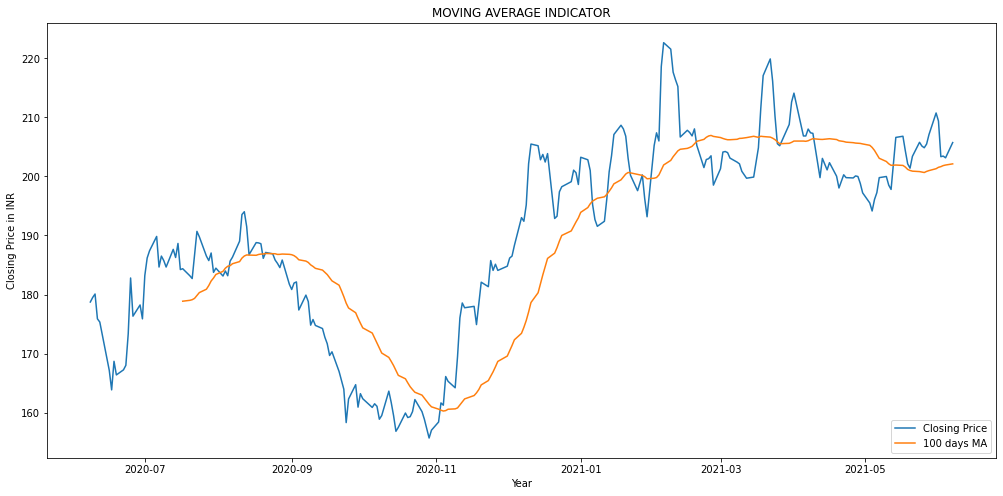

In [ ]:
#Plotting Moving Average wrt to Closing Price

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.title("MOVING AVERAGE INDICATOR")

#Let's go
plt.plot(df1[['Close','Moving_Avg']])
plt.legend(["Closing Price", "100 days MA"], loc ="lower right")
plt.show()

### **I2: Exponential Moving Average (EMA)**

In [ ]:
#Defining Function

def EMA(data, window_size):

  data1 = data
  data1 = pd.Series(data1["Close"])

  #Calculating Exponential Moving average for a given time period
  exponential_ma = data1.ewm(span = window_size, adjust = False).mean()
  #Parsing the results as a new column in the existing data frame
  data["Exponential_MA"] = exponential_ma

  return data

In [ ]:
#Implementing the function
EMA(df1,30)
df1.head()

,Close,Moving_Avg,Exponential_MA
Date,,,
2020-06-08,178.742,NaN,178.742004
2020-06-09,179.51,NaN,178.791572
2020-06-10,180.098,NaN,178.875846
2020-06-11,175.895,NaN,178.683520
2020-06-12,175.352,NaN,178.468612


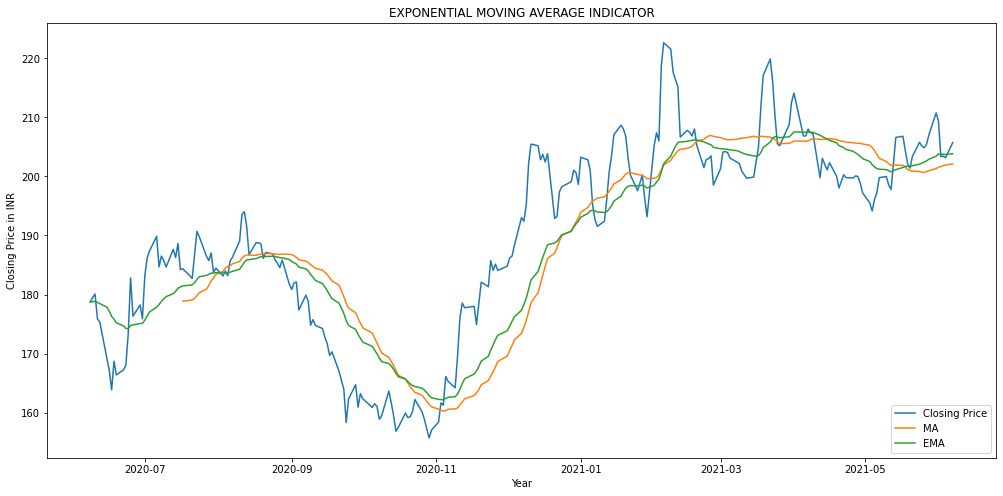

In [ ]:
#Plotting Exponential Moving Average wrt to Closing Price

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")

plt.ylabel("Closing Price in INR")
plt.title("EXPONENTIAL MOVING AVERAGE INDICATOR")

#Let's go
plt.plot(df1[['Close','Moving_Avg','Exponential_MA']])
plt.legend(["Closing Price","MA","EMA"], loc ="lower right")
plt.show()

In [ ]:
df1 = df1.drop(columns=['Moving_Avg', 'Exponential_MA'])

### **I3: Relative Strength Index (RSI)**

In [ ]:
#Defining Function

def get_RSI(data):
  
  data1 = data
  diff = data1['Close'].diff()
    
  #Up change is equal to the positive difference, otherwise equal to zero
  Up = diff.clip(lower=0)
  #Down change is equal to negative deifference, otherwise equal to zero
  Down = -1*diff.clip(upper=0)

  Up_Change_Avg = Up.ewm(com = 13, adjust = False).mean()
  Down_Change_Avg = Down.ewm(com = 13, adjust = False).mean()

  Relative_Strength = (Up_Change_Avg/Down_Change_Avg)
  RSI = 100 - (100/(1+Relative_Strength))
  data['RSI'] = RSI 

  return data

In [ ]:
#Implementing the function
get_RSI(df1)
df1.head()

,Close,RSI
Date,,
2020-06-08,178.742,NaN
2020-06-09,179.51,100.000000
2020-06-10,180.098,100.000000
2020-06-11,175.895,70.027602
2020-06-12,175.352,67.227558


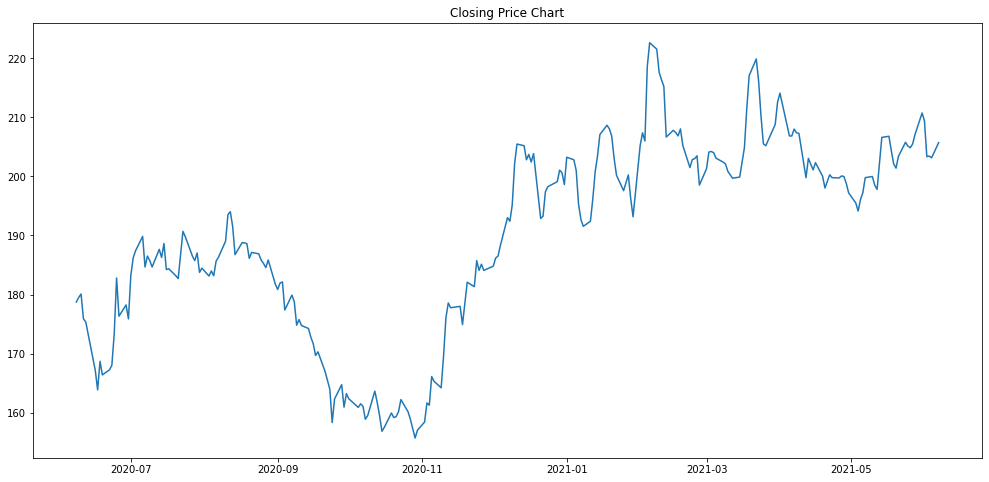

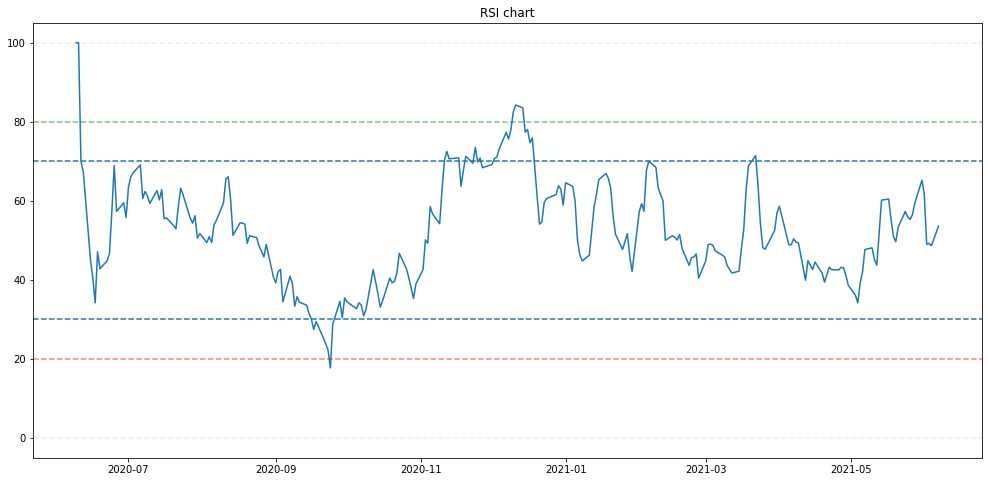

In [ ]:
#Plotting RSI 

#Plotting Closing Price
plt.figure(figsize=(17,8))
plt.plot(df1['Close'])
plt.title('Closing Price Chart')
plt.show()

#Plotting corresponding RSI values and significant levels
plt.figure(figsize=(17,8))
plt.title('RSI chart')
plt.plot(df1['RSI'])

#Significant Level A
plt.axhline(0, linestyle='--', alpha=0.1, color = 'g')
plt.axhline(20, linestyle='--', alpha=0.5, color = 'r')
plt.axhline(30, linestyle='--')

#Significant Level B
plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5, color = 'g')
plt.axhline(100, linestyle='--', alpha=0.1, color = 'r')
plt.show()

In [ ]:
df1 = df1.drop(columns=['RSI'])

### **I4: Stochastic Oscillator**

In [ ]:
#Defining Function

def Stochastic_Oscillator(data, ticker):

  data1 = data

  #Upper and Lower Levels in 14 day window
  data1['H14'] = data1['High'].rolling(14).max()
  data1['L14'] = data1['Low'].rolling(14).min()

  #Current value of Stochastic Oscillator
  data1['%K'] = (data1['Close'] - data1['L14'])*100/(data1['H14'] - data1['L14'])
  #3-day MA of %K
  data1['%D'] = data1['%K'].rolling(3).mean()

  ticker['%K'] = data1['%K'].values
  ticker['%D'] = data1['%D'].values

  return ticker

In [ ]:
#Implementing Function
Stochastic_Oscillator(df,df1)
df1.tail()

,Close,%K,%D
Date,,,
2021-06-01,209.374,74.848441,78.859846
2021-06-02,203.342,32.131153,66.013085
2021-06-03,203.439,17.999966,41.659853
2021-06-04,203.147,15.599910,21.910343
2021-06-07,205.726,36.799922,23.466599


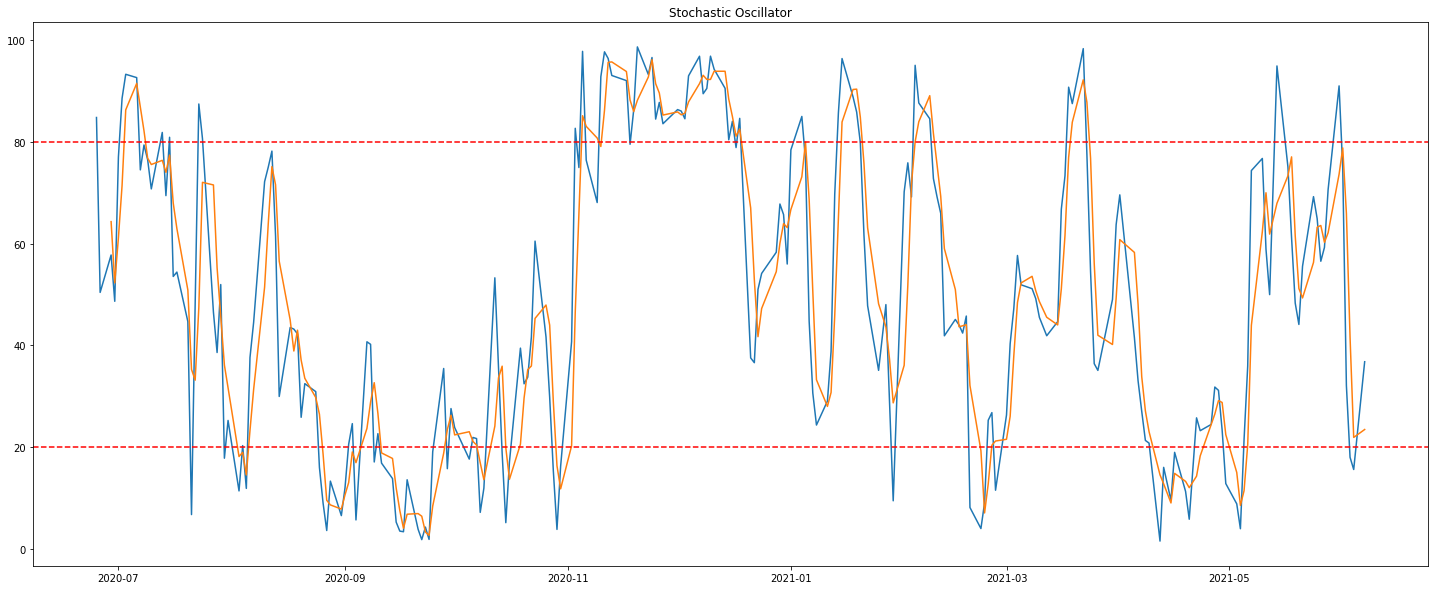

In [ ]:
#Plotting Stochastic Oscillator
plt.figure(figsize=(25,10))
plt.plot(df1[['%K', '%D']])

plt.title("Stochastic Oscillator")
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")

plt.show()

In [ ]:
df1.drop(columns=['%K','%D'], inplace=True)

### **I5: Bollinger Bands**

In [ ]:
#Defining Function

def BollingerB(data,window_size):

  #Calculate rolling mean and standard deviation using number of days set above
  rolling_mean = data['Close'].rolling(window_size).mean()
  rolling_std = data['Close'].rolling(window_size).std()

  #create two new DataFrame columns to hold values of upper and lower Bollinger bands
  data['Bollinger High'] = rolling_mean + (rolling_std*2)
  data['Bollinger Low'] = rolling_mean - (rolling_std*2)

  return data

In [ ]:
#Implementing the function

BollingerB(df1,20)
df1.tail()

,Close,Bollinger High,Bollinger Low
Date,,,
2021-06-01,209.374,211.975086,193.697171
2021-06-02,203.342,211.468527,195.123147
2021-06-03,203.439,211.100131,196.226105
2021-06-04,203.147,210.767144,197.147713
2021-06-07,205.726,210.811988,197.696355


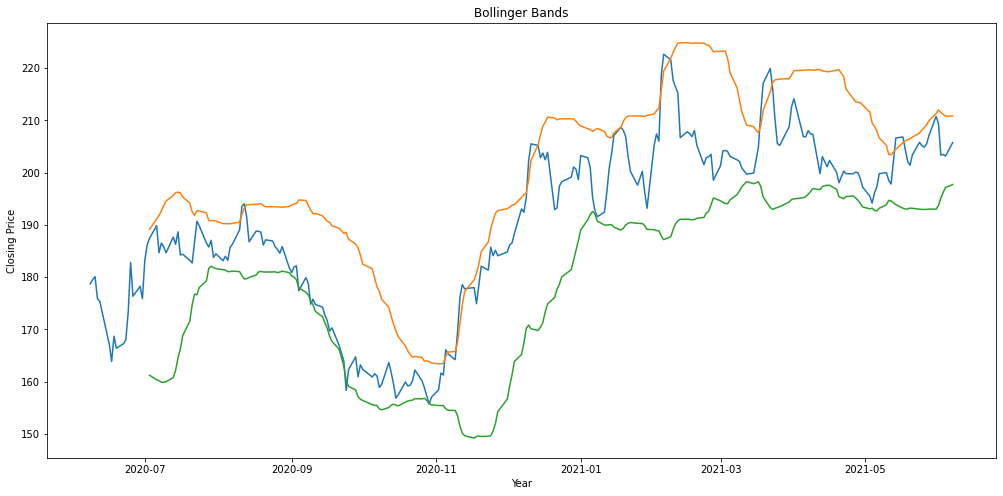

In [ ]:
#Plotting

plt.figure(figsize=(17,8))

plt.plot(df1[['Close','Bollinger High','Bollinger Low']])

plt.title("Bollinger Bands")
plt.xlabel("Year")
plt.ylabel("Closing Price")

plt.show()

In [ ]:
df1.drop(columns= ['Bollinger High','Bollinger Low'], inplace=True)

### **I6: Moving average convergence divergence (MACD)**

In [ ]:
#Defining Function

def MACD(data, slow, fast, smooth):

    exp1 = data['Close'].ewm(span = fast, adjust = False).mean()
    exp2 = data['Close'].ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2)

    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())

    data['MACD'] = macd.values
    data['Signal'] = signal.values

    return data

In [ ]:
#Implementing the Function

MACD(df1, 26, 12, 9)
df1.tail()

,Close,MACD,Signal
Date,,,
2021-06-01,209.374,1.770135,0.817326
2021-06-02,203.342,1.447876,0.943436
2021-06-03,203.439,1.186655,0.992080
2021-06-04,203.147,0.945187,0.982701
2021-06-07,205.726,0.950905,0.976342


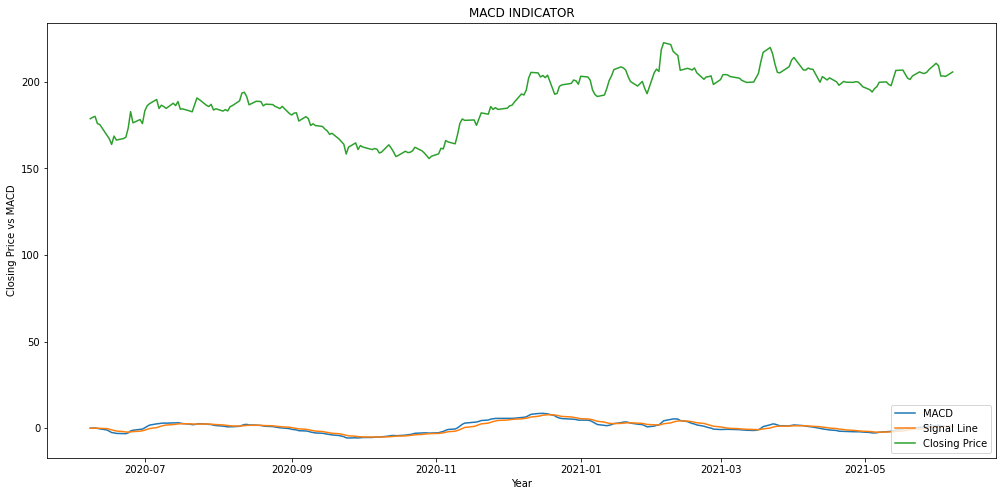

In [ ]:
#Plotting 

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")

plt.ylabel("Closing Price vs MACD")
plt.title("MACD INDICATOR")

#Let's go
plt.plot(df1[['MACD', 'Signal', 'Close']])
plt.legend(["MACD","Signal Line","Closing Price"], loc ="lower right")
plt.show()

In [ ]:
df1.drop(columns = ['MACD','Signal'], inplace=True)

### **I7: Money Flow Index (MFI)**

In [ ]:
#Defining Function

def MFI(data, period):

  #Calculating the typical price
  typical_price = (data['Close'] + data['High'] + data['Low']) / 3

  #Calculate the money flow
  money_flow = typical_price * data['Volume']

  #Get all of the positive and negative money flows 
  positive_flow =[]
  negative_flow = []

  for i in range(1, len(typical_price)):
    if typical_price[i] > typical_price[i-1]: #if the present typical price is greater than yesterdays typical price
      positive_flow.append(money_flow[i-1])# Then append money flow at position i-1 to the positive flow list
      negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]:#if the present typical price is less than yesterdays typical price
      negative_flow.append(money_flow[i-1])# Then append money flow at position i-1 to negative flow list
      positive_flow.append(0)
    else:
      positive_flow.append(0)
      negative_flow.append(0)
  
  #Get all of the positive and negative money flows within the time period
  positive_mf =[]
  negative_mf = [] 

  for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i+1-period : i+1]))
  for i in range(period-1, len(negative_flow)):
    negative_mf.append(sum(negative_flow[i+1-period : i+1]))

  #Calculating MFI
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf) ))

  #Creating a new DataFrame as MFI and df was different indices by delta

  new_df = pd.DataFrame()
  new_df = data[period:]
  new_df['MFI'] = MFI

  return MFI, new_df

In [ ]:
#Implementing Function

Money_Flow_Index, new_df = MFI(df,14)
new_df.head()

,Date,Open,High,Low,Close,Volume,H14,L14,%K,%D,MFI
14,2020-06-26,185.747074,189.136619,174.719756,176.346741,5776272,189.136619,163.330867,50.437879,NaN,63.041321
15,2020-06-29,183.577750,183.577750,177.386176,178.244858,2641793,189.136619,163.330867,57.793282,64.357905,47.483800
16,2020-06-30,181.679608,181.679608,175.352458,175.894791,1763570,189.136619,163.330867,48.686525,52.305895,45.179282
17,2020-07-01,176.256339,184.210474,176.120763,183.216202,1762903,189.136619,163.330867,77.057762,61.179189,50.402343
18,2020-07-02,184.662399,186.876899,183.170991,186.198990,1427773,189.136619,163.330867,88.616379,71.453555,55.046204


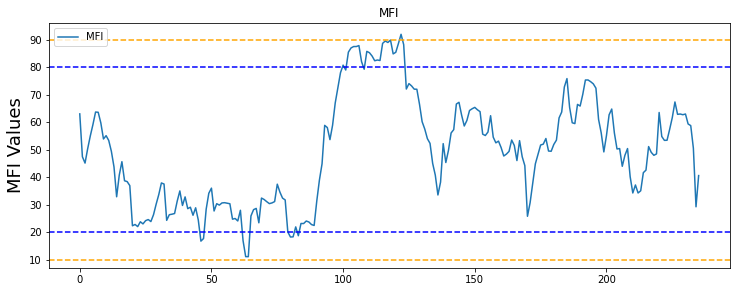

In [ ]:
#Plotting The Money Flow Index
df2 = pd.DataFrame()
df2['MFI'] = Money_Flow_Index

plt.figure(figsize=(12.2,4.5))
plt.plot( df2['MFI'],  label='MFI')

plt.axhline(10, linestyle='--', color = 'orange')  #Over Sold line (Buy)
plt.axhline(20, linestyle='--',color = 'blue')  #Over Sold Line (Buy)
plt.axhline(80, linestyle='--', color = 'blue')  #Over Bought line (Sell)
plt.axhline(90, linestyle='--', color = 'orange')  #Over Bought line (Sell)

plt.title('MFI')
plt.ylabel('MFI Values',fontsize=18)
plt.legend(df2.columns.values, loc='upper left')

plt.show()

# **SECTION 3: DASHBOARD**

In this section, we will be 